In [1]:
### loading data        V
#   inspection          V
#   training / validation split
#   augmentation
#     generator
#     flipping
import pandas as pd
import scipy.misc
import random
import numpy as np
import cv2
import time
import pickle 

#read data.txt
driving_log=pd.read_csv('./data/driving_log.csv').sample(frac=1.0)


driving_log.describe()


steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360

In [3]:
df_no_zero = driving_log[driving_log.steering != 0]
df_zero = driving_log[driving_log.steering == 0]

print("Non-zero steering data: %d"%(df_no_zero.size))
print("Zero steering angle data: %d"%(df_zero.size))
df = df_no_zero.append(df_zero.sample(frac=0.1))
print("Total data set: %d"%(df.size))

Non-zero steering data: 25725
Zero steering angle data: 30527
Total data set: 28777


In [6]:
#get number of images
num_images = len(df)

#split train/validation data set
msk = np.random.rand(num_images) < 0.8
train = df[msk]
valid = df[~msk]

print('total number: {}, reserved for training: {}, validation: {}'.format(num_images, len(train), len(valid)))

def LoadTrainBatch(batch_size):
    x_out = []
    y_out = []
    batch = train.sample(batch_size).as_matrix()
    
    i = 0
    for row in batch:
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[0].strip()), (96,48)) / 255 -0.5)
        y_out.append(row[3])
        
        # add left image
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[1].strip()), (96,48)) / 255 -0.5)
        y_out.append(min(1, row[3] +0.1))
        
        # add right image
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[2].strip()), (96,48)) / 255 -0.5)
        y_out.append(max(-1, row[3] -0.1))
        
        i += 1
    return np.array(x_out), np.array(y_out)

def LoadValBatch(batch_size):
    x_out = []
    y_out = []
    batch = valid.sample(batch_size).as_matrix()
    for row in batch:
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[0].strip()), (96,48)) / 255 -0.5)
        y_out.append(row[3])
    return np.array(x_out), np.array(y_out)

xCenter_train, y_train = LoadTrainBatch(len(train))
xCenter_valid, y_valid = LoadTrainBatch(len(valid))


total number: 4111, reserved for training: 3323, validation: 788


In [11]:
print('total number: {}'.format(len(xCenter_train)))
pdata = {'xCenter_train':xCenter_train, 'y_train':y_train, 'xCenter_valid':xCenter_valid, 'y_valid':y_valid}
f = open('./data.p', 'wb')   
pickle.dump(pdata, f)      
f.close() 

total number: 9969


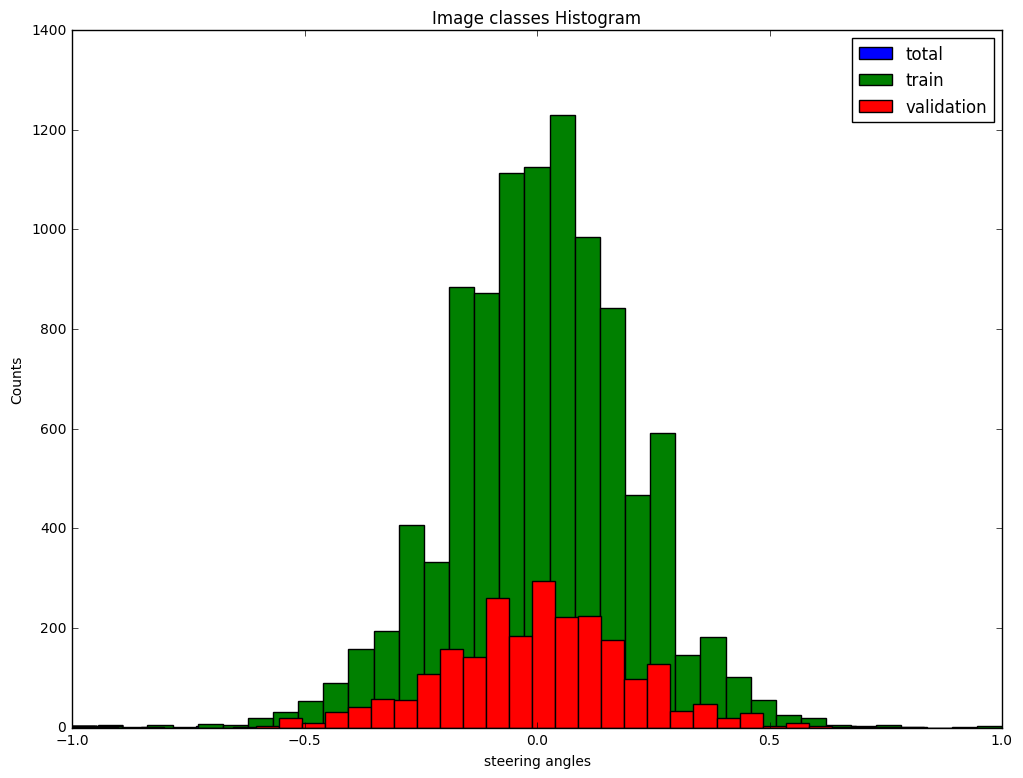

In [7]:
### inspection
import matplotlib.pyplot as plt
%matplotlib inline
def inspectHistogram():
    pltChangeSize()
    
    plt.hist(df.steering, bins=37, label='total')
    plt.hist(y_train, bins=37, label='train')
    plt.hist(y_valid, bins=37, label='validation')

    plt.title('Image classes Histogram')  
    plt.xlabel('steering angles')  
    plt.ylabel('Counts')  
    plt.legend()  

def pltChangeSize():
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size

inspectHistogram()

4 Steering angle between -1.1 and -0.9
./data/IMG/left_2016_12_01_13_39_28_126.jpg


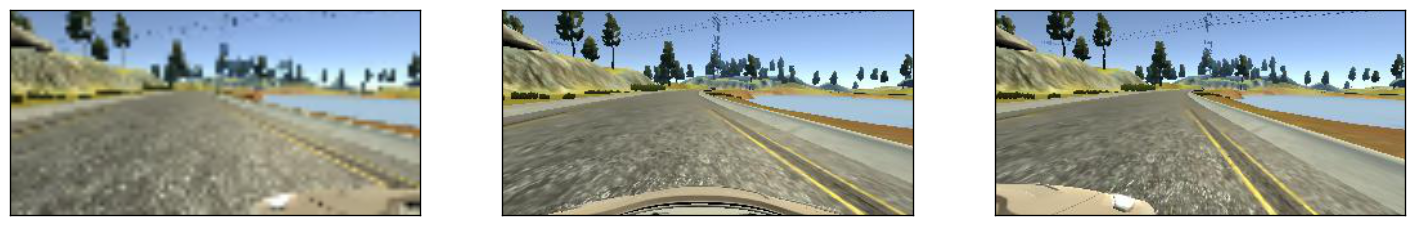

3 Steering angle between -0.9 and -0.7
./data/IMG/left_2016_12_01_13_38_26_704.jpg


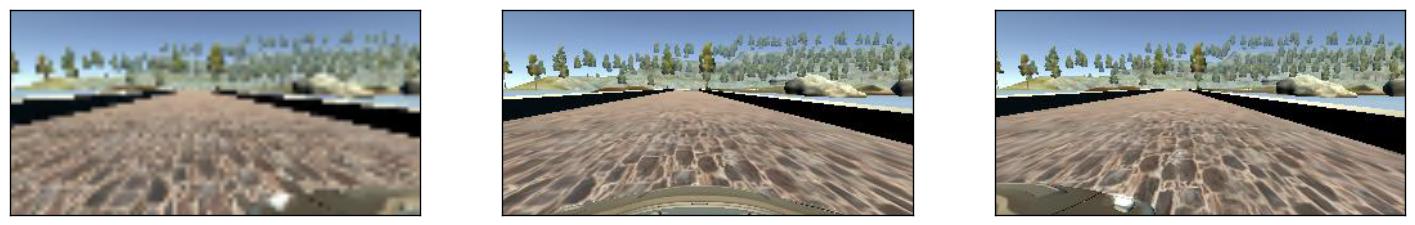

17 Steering angle between -0.7 and -0.5
./data/IMG/left_2016_12_01_13_39_59_398.jpg


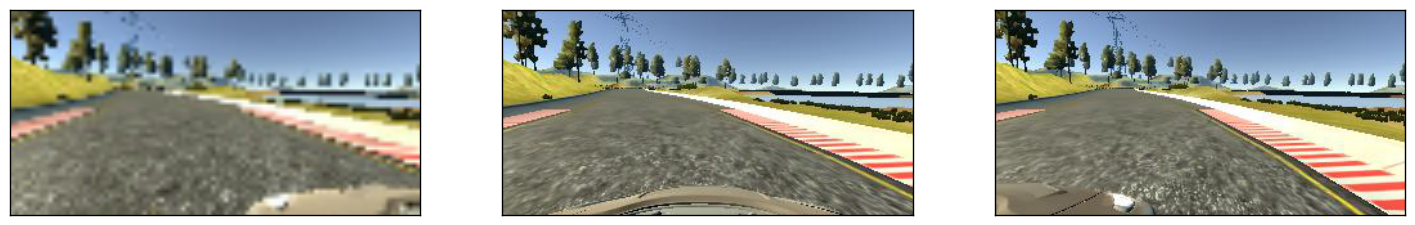

140 Steering angle between -0.5 and -0.3
./data/IMG/left_2016_12_01_13_39_52_094.jpg


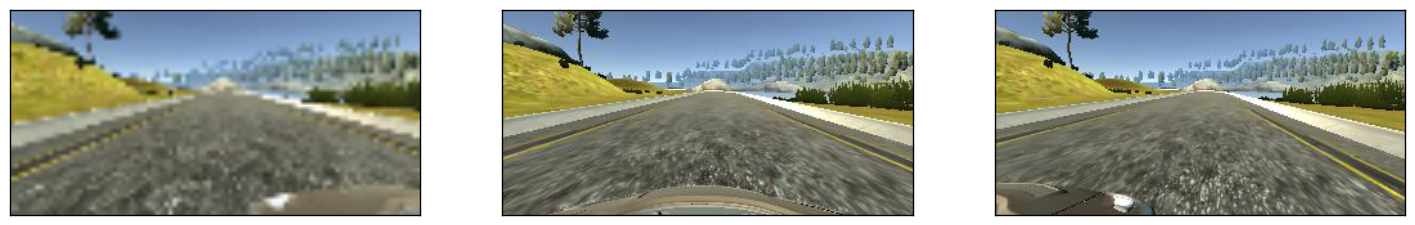

773 Steering angle between -0.3 and -0.1
./data/IMG/left_2016_12_01_13_44_02_028.jpg


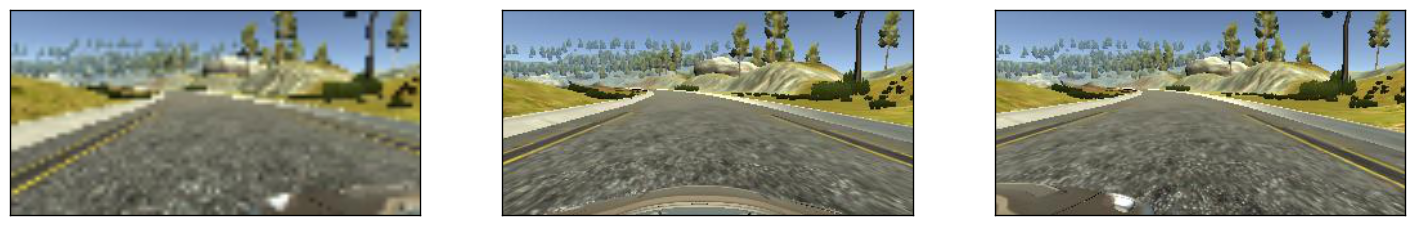

5923 Steering angle between -0.1 and 0.1
./data/IMG/left_2016_12_01_13_37_04_543.jpg


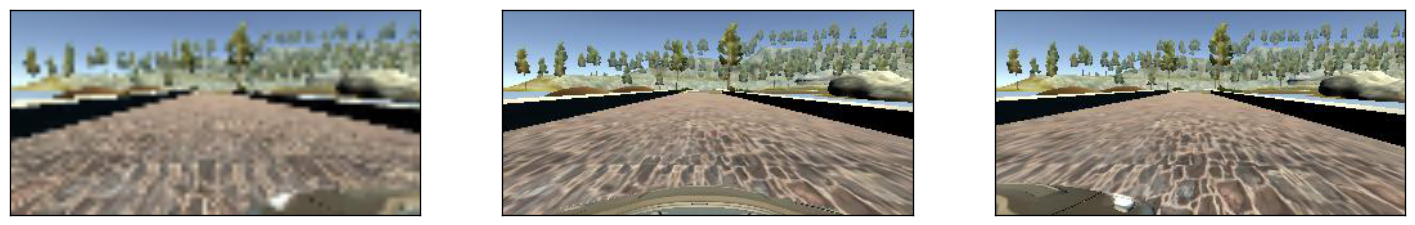

942 Steering angle between 0.1 and 0.3
./data/IMG/left_2016_12_01_13_45_38_931.jpg


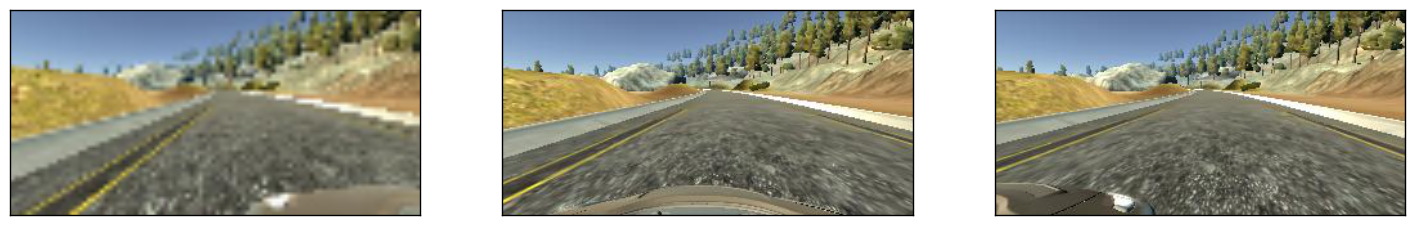

214 Steering angle between 0.3 and 0.5
./data/IMG/left_2016_12_01_13_35_00_840.jpg


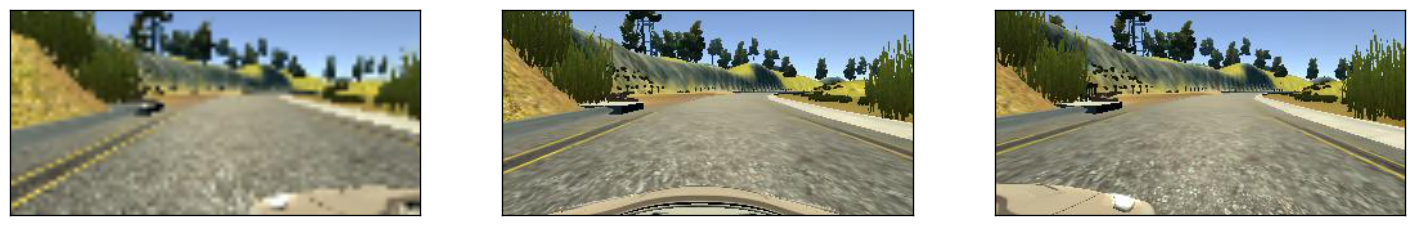

17 Steering angle between 0.5 and 0.7
./data/IMG/left_2016_12_01_13_32_43_963.jpg


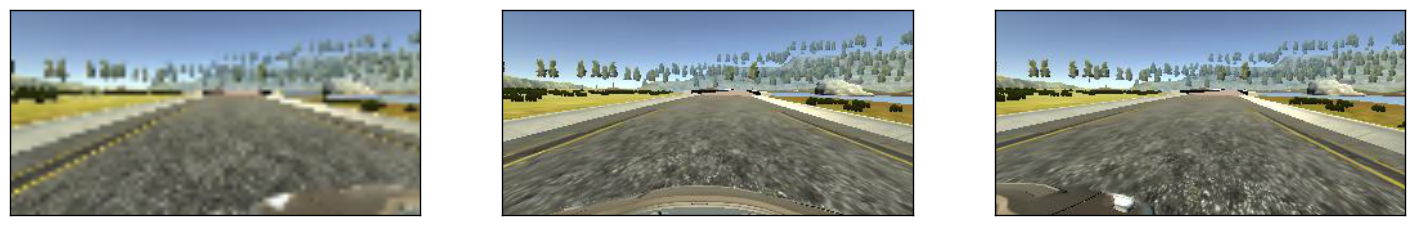

1 Steering angle between 0.7 and 0.9
./data/IMG/left_2016_12_01_13_38_59_461.jpg


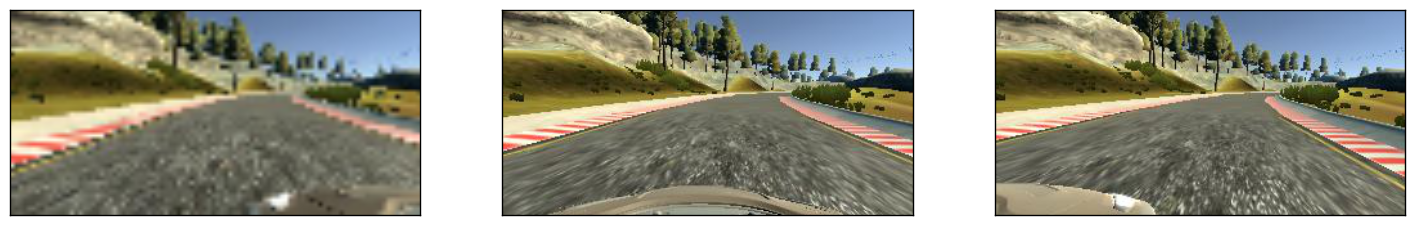

2 Steering angle between 0.9 and 1.1
./data/IMG/left_2016_12_01_13_38_42_894.jpg


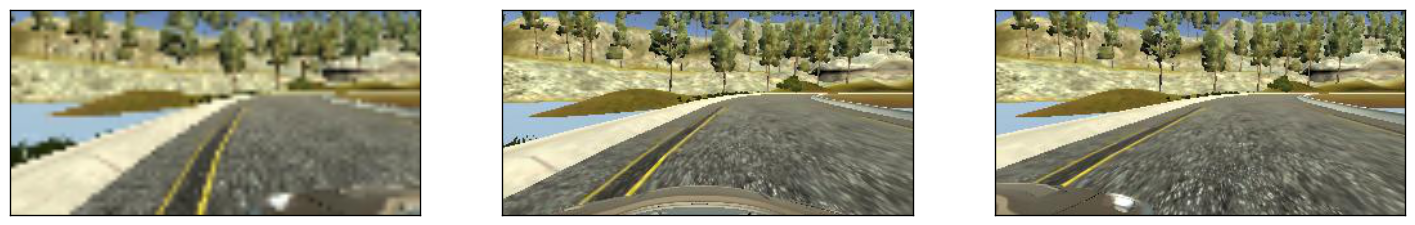

0 Steering angle between 1.1 and 1.3
./data/IMG/left_2016_12_01_13_38_42_894.jpg


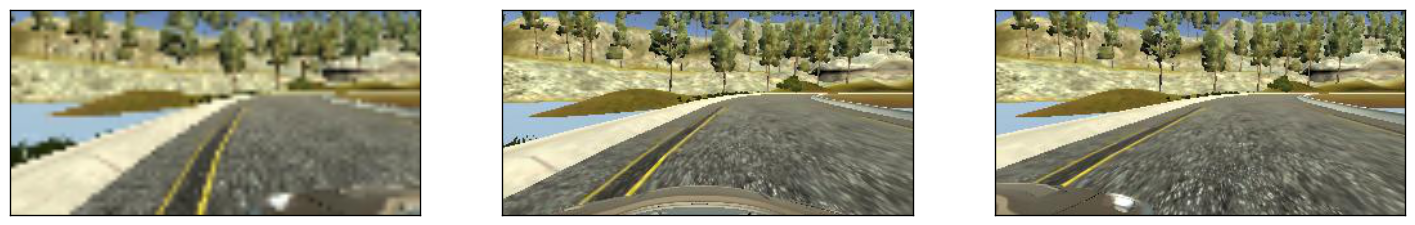

In [8]:


def frange(start, end, step):
    while start < end:
        yield start
        start += step
        
def plotImagesPerClass():
    pltChangeSize()
    step = 0.2
    classes = frange(-1.1, 1.1, step)

    for cls in classes:
        fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
        ceil = cls + step
        subset = driving_log.loc[(driving_log['steering'] >= cls) & (driving_log['steering'] < ceil)]
        print("{} Steering angle between {:.1f} and {:.1f}".format(len(subset), cls, ceil))
        
        if len(subset)>0:
            idx = subset.sample(1)
            
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        print('./data/' + idx['left'].iloc[0].strip())
        axes[0].imshow(cv2.resize(scipy.misc.imread('./data/' + idx['left'].iloc[0].strip()),(96,48)))

        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(scipy.misc.imread('./data/' + idx['center'].iloc[0].strip()))

        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].imshow(scipy.misc.imread('./data/' + idx['right'].iloc[0].strip()))


        plt.show()
            

    
plotImagesPerClass()